### Optimize a convolutional encoder to make a fixed input signal match a target signal

### Use this to explore the range of possible signals a convolutional encoder can map a delta function to

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *

sampling_indices = (3, 4)

## Generate a fixed delta function input signal

Text(0.5, 1.0, 'output signal')

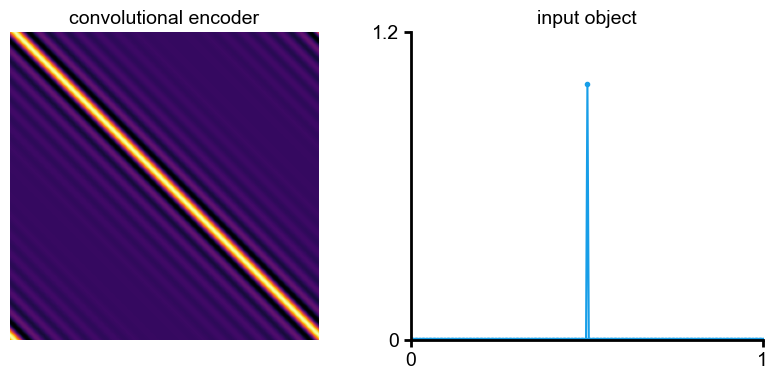

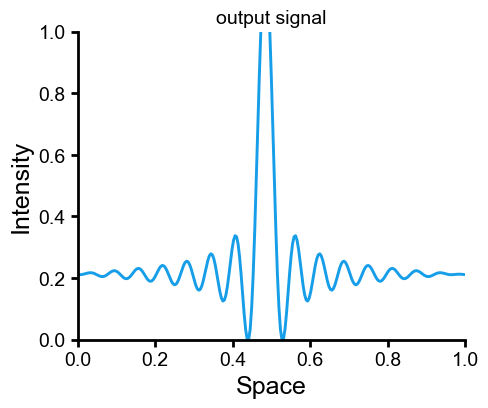

In [2]:
# signal = generate_random_1_over_f_signal(num_non_dc_in_bandlimit= 10)
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function
# input_signal = bandlimited_nonnegative_signal(delta_function)


# generate the convolutional encoder
nyquist_samples = onp.zeros(NUM_NYQUIST_SAMPLES)
nyquist_samples[-1] = 1
kernel = bandlimited_nonnegative_signal(nyquist_samples=np.array(nyquist_samples))

conv_mat = make_convolutional_encoder(kernel)
conv_mat_for_display = make_convolutional_encoder(kernel, sample=False)

# plot the input signal
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(conv_mat_for_display, cmap='inferno', interpolation=None)
ax[0].set_title('convolutional encoder')
# remove axes
ax[0].axis('off')


ax[1].plot(np.linspace(0,1, input_signal.size), input_signal,  '.-', label='input signal',)
ax[1].set_title('input object')
ax[1].set(xlim=(0,1))
default_format(ax[1])


# do the convolution
output_signal = conv_mat @ input_signal
# plot the output signal
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_spatial_coordinates(ax, output_signal, label='output signal')
ax.set_title('output signal')

# Optimize the convolution matrix to map a delta towards a target signal

initial loss 0.4639223


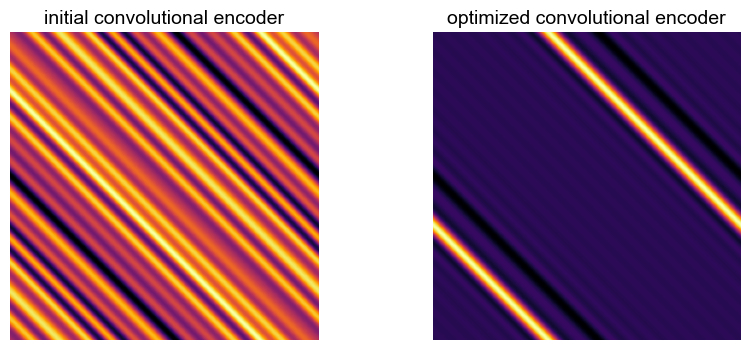

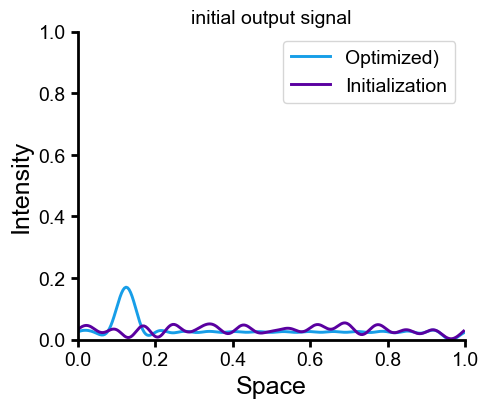

In [4]:

# generate a delta function target signal (cant be achieved because of bandlimit)
use_sampling_indices = True
sampling_indices = (3, 4)

delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
object = delta_function

target_signal = onp.zeros_like(generate_concentrated_signal(sampling_indices))
# target_signal[sampling_indices[0]] = 1
target_signal[sampling_indices[0]] = 0.5
target_signal[sampling_indices[1]] = 0.5

target_signal = np.array(target_signal)
# target_signal = bandlimited_nonnegative_signal(target_signal)


initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
loss_fn = make_convolutional_forward_model_and_target_signal_MSE_loss_fn(object, target_signal, 
                                                                         sampling_indices=sampling_indices if use_sampling_indices else None)
initial_params = params_from_signal(initial_kernel)
optimized_params = run_optimzation(loss_fn, prox_fn=signal_prox_fn, 
                         parameters=initial_params, learning_rate=1e-3, verbose=True)
optimized_kernel = signal_from_params(optimized_params)

# make the convolutional encoder from the optimized kernel
optimized_conv_mat = make_convolutional_encoder(optimized_kernel)
initial_conv_mat = make_convolutional_encoder(initial_kernel)


# plot the initial and optimized convolutional encoders
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(make_convolutional_encoder(initial_kernel, sample=False), cmap='inferno', interpolation=None)
ax[0].set_title('initial convolutional encoder')
ax[0].axis('off')

# plot the second convolutional encoder
ax[1].imshow(make_convolutional_encoder(optimized_kernel, sample=False), cmap='inferno', interpolation=None)
ax[1].set_title('optimized convolutional encoder')
ax[1].axis('off')


# another figure plotting the initial output signal and the optimized output signal
initial_output_signal = initial_conv_mat @ object
optimized_output_signal = optimized_conv_mat @ object

fig, ax = plt.subplots(1, 1, figsize=(5, 4))


plot_in_spatial_coordinates(ax, optimized_output_signal, label='Optimized)', color_samples=True)
ax.set_title('optimized output signal')

plot_in_spatial_coordinates(ax, initial_output_signal, label='Initialization', color_samples=True)
ax.set_title('initial output signal')


plot_in_spatial_coordinates(ax, target_signal, label='target signal', show_upsampled=False, 
                            marker='x', markersize=10, color_samples=False, 
                            sample_point_indices=sampling_indices if use_sampling_indices else None)

ax.legend()


# Make a grid of points to use as loss function targets

100%|██████████| 21/21 [04:06<00:00, 11.76s/it]


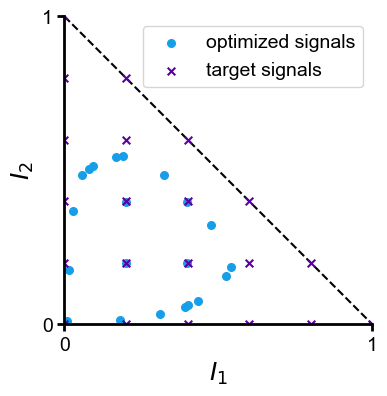

In [4]:

sampling_indices = (3, 4)
num_grid_points = 6

target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=num_grid_points)

optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, input_signal, sampling_indices)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)
ax.legend()

# 3D sampling grid

In [5]:
sampling_indices = (3, 4, 5)

target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=12)

optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, input_signal, sampling_indices)

100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


### 3D scatterplot

In [6]:


def make_3d_intenisty_coord_gif(name, target_signals, signals, sample_point_indices=(3,4,5), num_frames=50,
                                target_marker_size=6, signal_marker_size=30, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    images = []
    angle1 = np.concatenate([np.linspace(45, 85, num_frames // 2),
                            np.linspace(85, 5, num_frames )])
    angle2 = np.concatenate([np.linspace(5, 85, num_frames ),
                            np.linspace(85, 45, num_frames // 2)])
    angle1 = np.concatenate([np.ones_like(angle1) * 45, angle1])
    angle2 = np.concatenate([angle2, np.ones_like(angle2) * 45])
    angles = np.stack([angle1, angle2], axis=1)

    for i, ang in tqdm(enumerate(angles)):    
        ax.clear()
        ax.scatter(signals[..., sample_point_indices[0]], 
                    signals[..., sample_point_indices[1]], 
                    signals[..., sample_point_indices[2]], 
               s=signal_marker_size, label='Optimized', marker='.', **kwargs)
        ax.scatter(target_signals[..., sample_point_indices[0]], 
                    target_signals[..., sample_point_indices[1]], 
                    target_signals[..., sample_point_indices[2]],                     
                    linewidths=0.95,
               s=target_marker_size, label='Targets', marker='x', **kwargs)
 
        ax.set_xticks([0, 1])
        ax.set_xticks(np.arange(0, 1, 0.25), minor=True)  
        ax.set_yticks([0, 1])
        ax.set_yticks(np.arange(0, 1, 0.25), minor=True)
        ax.set_zticks([0, 1])
        ax.set_zticks(np.arange(0, 1, 0.25), minor=True)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_zlim(0, 1)
        ax.set_xlabel('$I_1$', rotation=0)
        ax.set_ylabel('$I_2$', rotation=0)
        ax.set_zlabel('$I_3$', rotation=0)

        ax.view_init(*ang)
        # Save the current frame to a temporary file
        temp_file = f'/home/hpinkard_waller/figures/1d_signals/tmpframes/frame_{i}.png'
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))  # Position the legend in the top right corner, away from the data
        fig.savefig(temp_file, dpi=300)
        # Load the saved image and append it to the images list
        images.append(imageio.imread(temp_file))

    # Save the list of images as an animated gif
    # delete everything in the tmpframes folder, using os.listdir
    for file in os.listdir('/home/hpinkard_waller/figures/1d_signals/tmpframes'):
        os.remove('/home/hpinkard_waller/figures/1d_signals/tmpframes/' + file)
    imageio.mimsave(f'/home/hpinkard_waller/figures/1d_signals/{name}.gif', images)

make_3d_intenisty_coord_gif('conv_optimized_delta_3d_scatter_plot', target_signals, output_signals, sampling_indices, num_frames=120)

0it [00:00, ?it/s]/tmp/ipykernel_15555/1736835574.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_file))
360it [01:35,  3.76it/s]


: 